# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Plot sat_score vs saf_s_11

<AxesSubplot:xlabel='saf_s_11', ylabel='sat_score'>

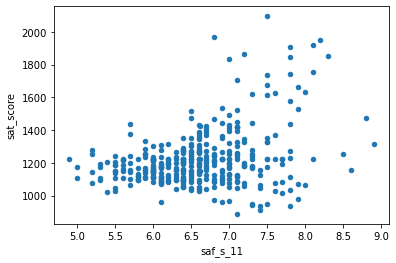

In [11]:
%matplotlib inline
combined.plot(kind="scatter", x="saf_s_11", y="sat_score")

#### Observations:
- Too many data points
- Large range of sat_scores for the schools with student's perception of sagfety between 6.6 and 8.0. 

#### Next Steps
- Avergage safety score per district
- Determine which district's school received higher average safety score by students. Show in a map

## Map out safety scores

In [12]:
import numpy as np

#Average of columns per district
grouped_district = combined.groupby("school_dist")
districts = grouped_district.agg(np.mean)
districts.reset_index(inplace=True)

### NOTE:
Basemap toolkit initially did not run properly, and following steps were taken to resolve the issues.<br>
1. dedent could not be found in C:\Users\sripa\anaconda3\Lib\site-packages\matplotlib\cbook\_init_.py. This was solved by adding the definition of dedent to _init_.py file as [shown here](https://www.youtube.com/watch?v=MCl6qY7VqRM).<br>
2. The definition of dedent was copied from [this website](https://matplotlib.org/3.1.1/_modules/matplotlib/cbook.html) and pasted in the _init_.py file, refer to the image below.<br>
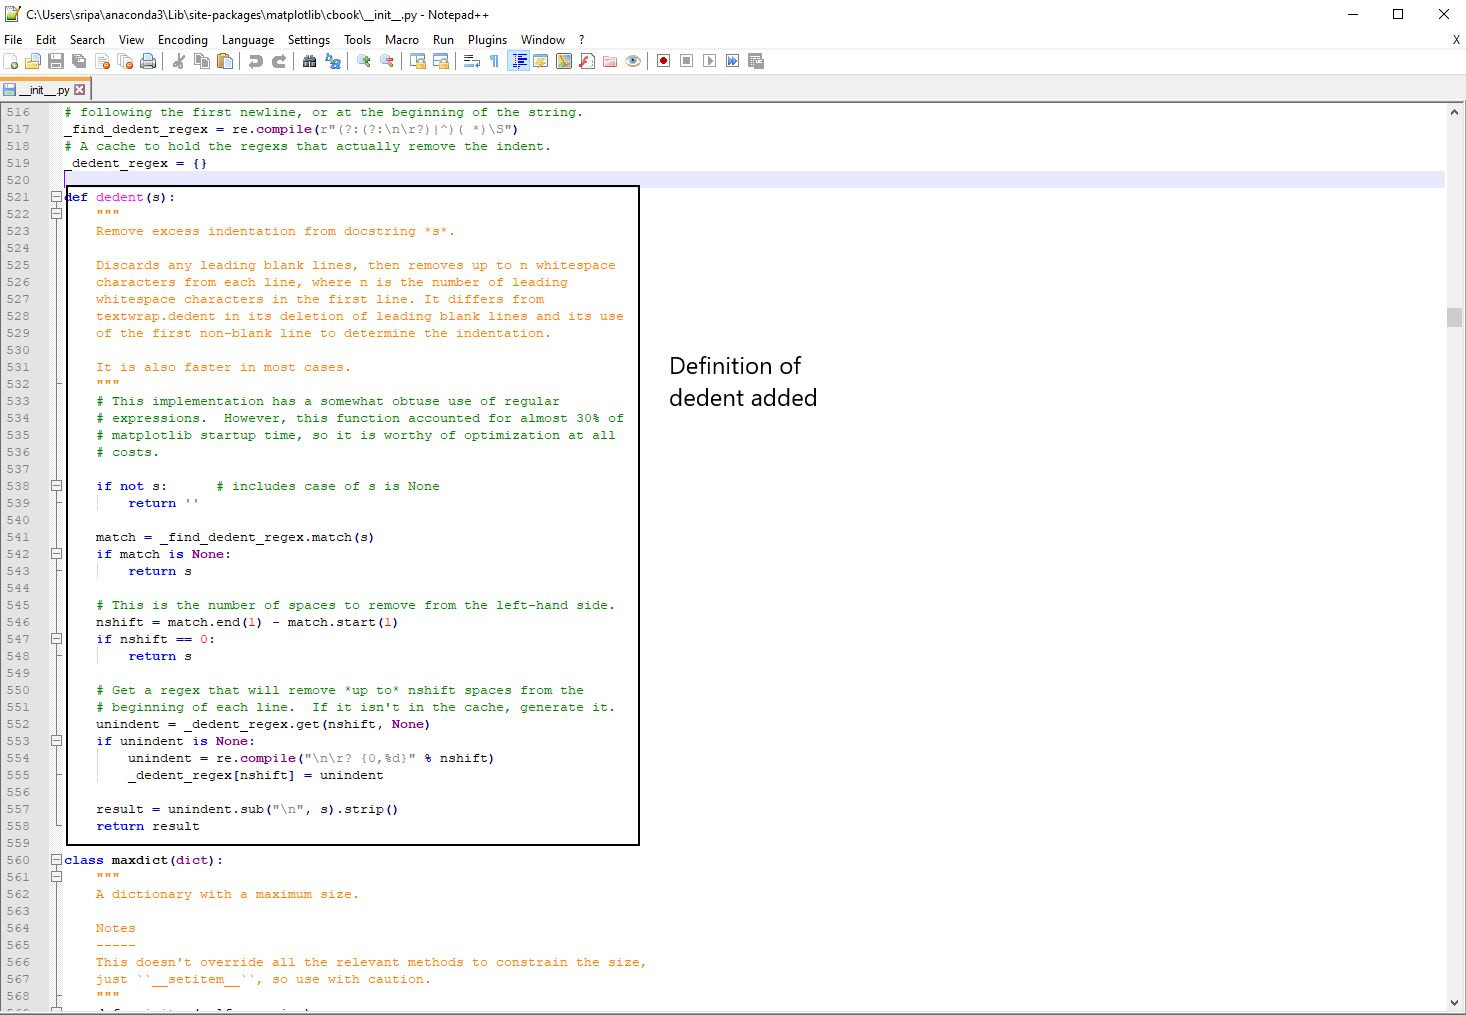
3. Above steps removed the dedentt error, but then a new error appeared, *OSError: Unable to open boundary dataset file. Only the 'crude' and  'low', resolution datasets are installed by default.* This was resolved by running conda install -c conda-forge basemap-data-hires on the terminal.


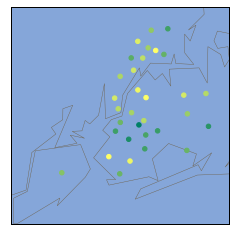

In [13]:
from mpl_toolkits.basemap import Basemap


#Map average safety score (student perception) per district
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True,c=districts["saf_s_11"], cmap="summer")

#### Observations:
- Bronx, Manhattan and Queen are considered safe by students.
- Brooklyn's school has low average avergae safety scores.

Text(0.5, 1.0, 'Correlation: sat scores vs racial percentages')

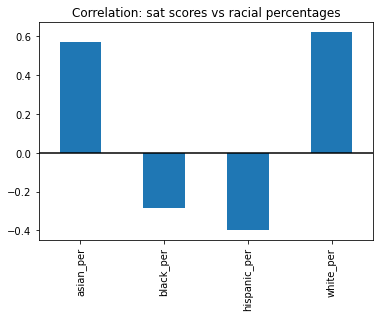

In [14]:
#correlation data of the sat_score with white_per, asian_per, black_per and hispanic_per
correlation = combined.corr()
intersted_indeces = ['asian_per', 'black_per', 'hispanic_per', 'white_per']
correlation_racial = correlation.loc[intersted_indeces,'sat_score']
ax = correlation_racial.plot(kind='bar')
ax.axhline(y=0, color='black')
ax.set_title("Correlation: sat scores vs racial percentages")

#### Observations:
- sat score is positively correlated with percentage of asians and white
- Negatively correlated with the % of black and hispanic students
- Large negative correlation with hispanic_per

## Explore schools with large hispanic percentage and low sat score 

<AxesSubplot:xlabel='hispanic_per', ylabel='sat_score'>

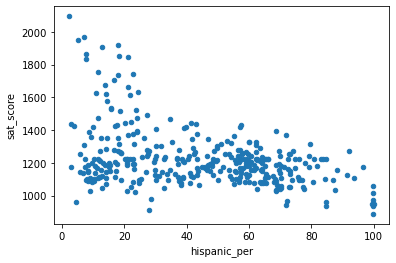

In [15]:
combined.plot(kind='scatter', y="sat_score", x="hispanic_per")

#### Observations:
- A cluster of schools on the bottom right with high percentage (approx. 100) of hispanic and low sat score. 
- Another cluster of schools at top left with low percentage (approx. 10) of hispanic and high stat score

## Investigate the schools with high hispanic_per

In [16]:
#Find the schools
schools_hhis = combined[combined["hispanic_per"] > 95]
schools_hhis["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

#### Observations:
- These schools provide eduction to kids from low income families or studnets in temporary housing
- Lack of financial support could be the actual reason for such low sat score in these schools

## Investigate the schools with low hispanic_per

In [17]:
#Find the schools
schools_lhis = combined[combined["hispanic_per"] < 10]
schools_lhis["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
220                           BOYS AND GIRLS HIGH SCHOOL
223    ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227                         SCHOOL FOR HUMAN RIGHTS, THE
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
229    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...
230        HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
237                           IT TAKES A VILLAGE ACADEMY
238                           B

In [18]:
schools_lhis["sat_score"].describe()

count      30.000000
mean     1318.414627
std       310.132878
min       963.000000
25%      1113.500000
50%      1180.500000
75%      1411.250000
max      2096.000000
Name: sat_score, dtype: float64

#### Observations:
- Sat score ranges from 963 to 2096
- Low hispanic percetage does not always mean better sat score. There are other factors that cause low sat score. Need ot investigate `schools_lhis` dataset further.  

## Correlation of sat score with percentage of gender

Text(0.5, 1.0, 'Correlation: sat scores vs gender percentages')

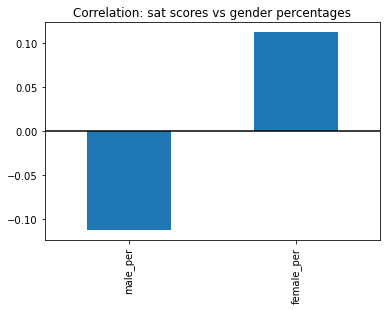

In [19]:
intersted_indeces = ['male_per', 'female_per']
correlation_gender = correlation.loc[intersted_indeces,'sat_score']
ax = correlation_gender.plot(kind='bar')
ax.axhline(y=0, color='black')
ax.set_title("Correlation: sat scores vs gender percentages")

The correlation of female is equal and opposite of that of male, which is clear from the plots of sat_score vs percentage of male or female. Since the per_male = 100 - per_female.

Will study only one plot that is relation of sat_score with the female_per.

<AxesSubplot:xlabel='male_per', ylabel='sat_score'>

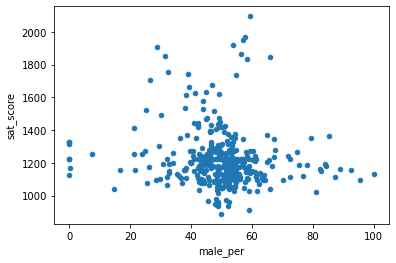

In [20]:
combined.plot(kind='scatter', y="sat_score", x="male_per")

<AxesSubplot:xlabel='female_per', ylabel='sat_score'>

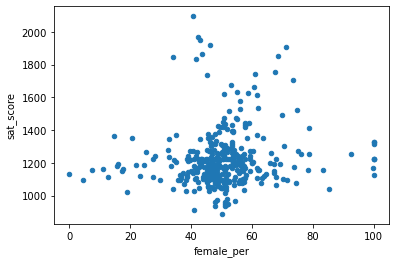

In [21]:
combined.plot(kind='scatter', y="sat_score", x="female_per")

- Positive correlations could be due to cluster of points at the top right.
- A group of schools with sat_score > 1700 and female_per > 60%. 

In [22]:
schools_hfem_hsat = combined[(combined["female_per"] > 70) & (combined["sat_score"] > 1700)]
schools_hfem_hsat["SCHOOL NAME"]

61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools have strict prerequisite grade standards in addition to examination to secure admission.

## Correlation of AP exam with SAT score

<AxesSubplot:xlabel='ap_per', ylabel='sat_score'>

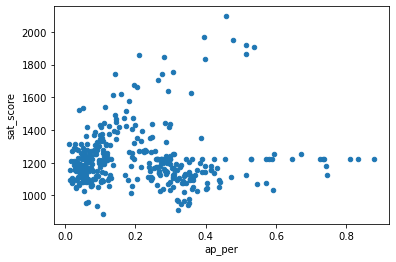

In [23]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined.plot(kind='scatter', y="sat_score", x="ap_per")